In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 1000

torch.backends.cudnn.enabled = True

In [2]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=batch_size_test, shuffle=True)

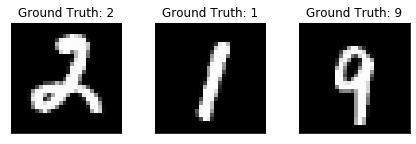

In [3]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

fig = plt.figure()
for i in range(3):
  plt.subplot(1,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,64,2,1,1)
        self.conv1_drop = nn.Dropout2d()
        self.conv2 = nn.Conv2d(64,32,2,1,1)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(7*7*32, 256)
        self.fc2 = nn.Linear(256, 10)
    def forward(self, x):
        x = self.conv1_drop(F.max_pool2d(F.relu(self.conv1(x)),2))
        x = self.conv2_drop(F.max_pool2d(F.relu(self.conv2(x)),2))
        x = x.view(-1, 7*7*32)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [5]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [6]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [7]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [8]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

C:\Users\44754\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\44754\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.2986, Accuracy: 1409/10000 (14%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.292467

Test set: Avg. loss: 0.2155, Accuracy: 9381/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.213642

Test set: Avg. loss: 0.1410, Accuracy: 9566/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.167681

Test set: Avg. loss: 0.1037, Accuracy: 9683/10000 (97%)



Text(0, 0.5, 'negative log likelihood loss')

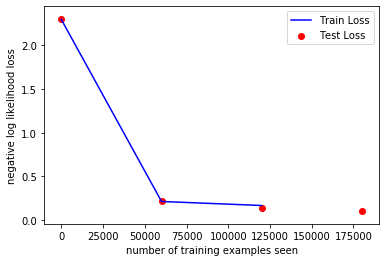

In [9]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [10]:
with torch.no_grad():
  output = network(example_data)

C:\Users\44754\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


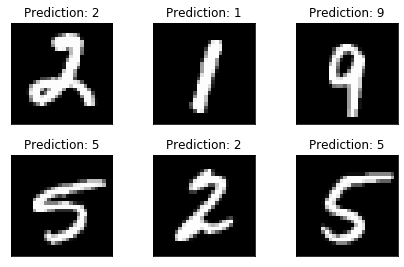

In [11]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])